### Generating matter distribution

All identical to galaxy distribution in first cell. No weight windows are generated, but are required to precompute the cls otherwise. I use the cls200 from the galaxy distribution.

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# uses the CAMB cosmology which produced the cls
import camb
from cosmology import Cosmology

# these are the GLASS imports: matter and random fields
import glass.shells
import glass.fields


# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = 1024
lmax = 1000

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 1., dx=200.)

# load precomputed angular matter power spectra from CAMB using ramp
cls = np.load('cls200.npy')

In [37]:
# compute Gaussian cls for lognormal fields with 3 correlated shells
gls = glass.fields.lognormal_gls(cls, ncorr=3, nside=nside)

# this generator will yield the matter fields in each shell
matter = glass.fields.generate_lognormal(gls, nside, ncorr=3)

After much imagination, in words, the bottom plot does the following. Imagine a spherical shell (glass shell) and a disk. Take only the top hemisphere of the entire shell, and place it on the disk. Color the glass shell with the density contrast. Project the shell vertically down, but only take the region of the shell for which the shell is defined. For example, although the shell we're sampling the density contrast from is technically thicknessless, the shells are bounded by a zmin and zmax. We assign the projected value from the sphere to the ring between zmin and zmax on the disk.

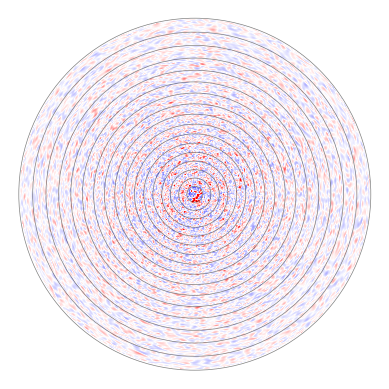

In [38]:
# make a 2d grid in redshift
n = 4000
zend = 1.05*zb[-1]
x, y = np.mgrid[-zend:zend:1j*n, -zend:zend:1j*n]
z = np.hypot(x, y)
grid = np.full(z.shape, np.nan)

# set up the plot
ax = plt.subplot(111)
ax.axis('off')

# simulate and project an annulus of each matter shell onto the grid
for i, delta_i in enumerate(matter):
    zmin, zmax = zb[i], zb[i+1]
    g = (zmin <= z) & (z < zmax)
    zg = np.sqrt(1 - (z[g]/zmax)**2)
    theta, phi = hp.vec2ang(np.transpose([x[g]/zmax, y[g]/zmax, zg]))
    grid[g] = hp.get_interp_val(delta_i, theta, phi)
    ax.add_patch(plt.Circle((0, 0), zmax/zend, fc='none', ec='k', lw=0.5, alpha=0.5, zorder=1))

# show the grid of shells
ax.imshow(grid, extent=[-1, 1, -1, 1], zorder=0,
          cmap='bwr', vmin=-1, vmax=1)

# show the resulting plot
plt.show()

In [31]:
hp.get_interp_val?

Signature: hp.get_interp_val(m, theta, phi, nest=False, lonlat=False)
Docstring:
Return the bi-linear interpolation value of map(s) using 4 nearest neighbours.

Parameters
----------
m : array-like, shape (npix,) or (nmaps, npix)
  a healpix map or sequence thereof, accepts masked arrays
theta, phi : float, scalar or array-like
  angular coordinates of point at which to interpolate the map
nest : bool
  if True, the is assumed to be in NESTED ordering.
lonlat : bool
  If True, input angles are assumed to be longitude and latitude in degree,
  otherwise, they are co-latitude and longitude in radians.

Returns
-------
val : float, scalar or array-like
  the interpolated value(s), usual numpy broadcasting rules apply.

See Also
--------
get_interp_weights, get_all_neighbours

Examples
--------
>>> import healpy as hp
>>> hp.get_interp_val(np.arange(12.), np.pi/2, 0)
4.0
>>> hp.get_interp_val(np.arange(12.), np.pi/2, np.pi/2)
5.0
>>> hp.get_interp_val(np.arange(12.), np.pi/2, np.pi/2 + 2*n

In [12]:
y.shape

(2000, 2000)

In [16]:
zg.shape

(432492,)

In [15]:
grid.shape

(2000, 2000)

In [17]:
hp.vec2ang?

Signature: hp.vec2ang(vectors, lonlat=False)
Docstring:
vec2ang: vectors [x, y, z] -> theta[rad], phi[rad]

Parameters
----------
vectors : float, array-like
  the vector(s) to convert, shape is (3,) or (N, 3)
lonlat : bool, optional
  If True, return angles will be longitude and latitude in degree,
  otherwise, angles will be co-latitude and longitude in radians (default)

Returns
-------
theta, phi : float, tuple of two arrays
  the colatitude and longitude in radians

See Also
--------
ang2vec, rotator.vec2dir, rotator.dir2vec
File:      /project/chihway/envs/glass/lib/python3.11/site-packages/healpy/pixelfunc.py
Type:      function